In [25]:
# coding: utf-8

import arrow
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

# get_ipython().magic('matplotlib inline')


image_size = 28  #图像的总尺寸28*28
num_classes = 10  #标签的种类数
num_epochs = 100  #训练的总循环周期
batch_size = 64


train_dataset = dsets.MNIST(root='./data',  #文件存放路径
                            train=True,   #提取训练集
                            transform=transforms.ToTensor(),  #将图像转化为Tensor
                            download=True)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

# 由于每一个样本需要输入两个图片，因此每一个loader和sampler都有两个

sampler1 = torch.utils.data.sampler.SubsetRandomSampler(
    np.random.permutation(range(len(train_dataset))))
sampler2 = torch.utils.data.sampler.SubsetRandomSampler(
    np.random.permutation(range(len(train_dataset))))

# 训练数据的两个加载器
train_loader1 = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           sampler = sampler1
                                           )
train_loader2 = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           sampler = sampler2
                                           )

# 校验数据和测试数据都各自有两套
val_size = 5000
val_indices1 = range(val_size)
val_indices2 = np.random.permutation(range(val_size))
test_indices1 = range(val_size, len(test_dataset))
test_indices2 = np.random.permutation(test_indices1)
val_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(val_indices1)
val_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(val_indices2)

test_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(test_indices1)
test_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(test_indices2)

val_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        sampler = val_sampler1
                                        )
val_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        sampler = val_sampler2
                                        )
test_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         sampler = test_sampler1
                                         )
test_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         sampler = test_sampler2
                                         )


# # MINST Adder

# 为了实现加法器，需要同时处理两个手写体数字图像，并对它进行相应的图像处理
# 因此，网络的架构为两个卷积神经网络，串联上两个全链接层

# In[13]:


depth = [50, 100, 500]
class MINSTAdder(nn.Module):
    def __init__(self):
        super(MINSTAdder, self).__init__()
        #处理第一个图像处理用的卷积网络部件
        self.net_pool = nn.MaxPool2d(2, 2)
        self.bn = nn.BatchNorm1d(50)


        self.net1_conv1 = nn.Conv2d(1, depth[0], 5, padding = 2)
        self.net1_conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2)
        self.net1_conv3 = nn.Conv2d(depth[1], depth[2], 5, padding = 2)
        # self.net1_conv4 = nn.Conv2d(depth[2], depth[3], 5, padding = 2)
        # self.net1_conv5 = nn.Conv2d(depth[3], depth[4], 5, padding = 2)

        #处理第二个图像处理用的卷积网络部件
        self.net2_conv1 = nn.Conv2d(1, depth[0], 5, padding = 2)
        self.net2_conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2)
        self.net2_conv3 = nn.Conv2d(depth[1], depth[2], 5, padding = 2)
        # self.net2_conv4 = nn.Conv2d(depth[2], depth[3], 5, padding = 2)
        # self.net2_conv5 = nn.Conv2d(depth[3], depth[4], 5, padding = 2)

        #后面的全连阶层
        self.fc1 = nn.Linear(2 * (image_size // 4 // 2) * (image_size // 4 // 2) * depth[2] , 1000)
        self.fc2 = nn.Linear(1000, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x, y, training = True):
        #第一张图像的处理流程
        x = F.leaky_relu(self.net1_conv1(x))
        x = self.net_pool(x)
        x = F.leaky_relu(self.net1_conv2(x))
        x = self.net_pool(x)
        x = F.leaky_relu(self.net1_conv3(x))
        x = self.net_pool(x)
        x = x.view(-1, (image_size // 4 // 2) * (image_size // 4 // 2)  * depth[2])

        #第二张图像的处理流程
        y = F.leaky_relu(self.net2_conv1(y))
        y = self.net_pool(y)
        y = F.leaky_relu(self.net2_conv2(y))
        y = self.net_pool(y)
        y = F.leaky_relu(self.net2_conv3(y))
        y = self.net_pool(y)
        y = y.view(-1, (image_size // 4 // 2) * (image_size // 4 // 2) * depth[2])

        #将前两部处理得到的张量并列到一起，喂给两层全链接前馈网络，最后输出预测数值
        z = torch.cat((x, y), 1)
        z = self.fc1(z)
        z = F.leaky_relu(z)
        z = F.dropout(z, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        z = self.fc2(z)
        z = F.leaky_relu(z)
        z = self.bn(z)
#        z = F.dropout(z, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        z = self.fc3(z)

        return z

# 计算准确度的函数（有多少数字给出了严格的正确输出结果）
def rightness_(y, target):
    out = torch.round(y).type(torch.LongTensor)
    # print('target is ', target)
    # print('out is ',out.data.view_as(target))
    # out = out.data
    # print(type(out))
    # print(type(target))
    # out = out.eq(target.view_as(out)).sum()
    target = target.eq(out.data.view_as(target)).sum()
    out1 = y.size()[0]
    # out = out.data[0]
    # out1 = len(target)
    return(target, out1)


def rightness(y, target):
    out = torch.round(y.view(-1)).type(torch.LongTensor)
    out = out.eq(target).sum()
    out1 = y.size()[0]
    return (out, out1)

# 将网络定义为一个预测器，来对加法的结果进行预测，因此用MSE平均平房误差作为我们的损失函数
net = MINSTAdder()
net = net.cuda()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.5)
results = {}


# In[15]:


# 开始训练循环，本部分代码需要补齐
records = []
for epoch in range(num_epochs):
    train_rights = []
    losses = []
    # 一个关键技术难点是对两个数据加载器进行读取成对儿的数据。我们的办法是通过zip命令，将loader1和2并列在一起，一对一对的读取数据
    for batch_idx, data in enumerate(zip(train_loader1, train_loader2)):
        ((x1, y1), (x2, y2)) = data
        labels = y1 + y2
        # labels = Variable(labels.type(torch.FloatTensor))
        net.train()
        outputs = net(Variable(x1).cuda(), Variable(x2).cuda())

        # loss = criterion(outputs, Variable(labels.type(torch.FloatTensor)).cuda())
        loss = criterion(outputs, Variable(labels.type(torch.FloatTensor)).cuda())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        right = rightness(outputs.data, labels)
        train_rights.append(right)
        losses.append(loss.data.cpu())

        if batch_idx % 300 == 0:
            net.eval()
            val_rights = []
            for idx, data in enumerate(zip(val_loader1, val_loader2)):
                ((x1, y1), (x2, y2)) = data
                outputs = net(Variable(x1).cuda(), Variable(x2).cuda())
                labels = y1+y2
                # labels = Variable(labels.type(torch.FloatTensor))
                right = rightness(outputs.data, labels)
                val_rights.append(right)

            train_r = np.sum([tup[0] for tup in train_rights]) / float(np.sum([tup[1] for tup in train_rights])) * 100.
            val_r = np.sum([tup[0] for tup in val_rights]) / float(np.sum([tup[1] for tup in val_rights])) * 100.

            print('epoch: {} [{}/{} ({:.0f}%)]\t acc on train: {:.4f}%\t acc on val: {:.4f}%\t{}'.format(
                epoch, batch_idx * batch_size, len(train_loader1.dataset), 100. * batch_idx / len(train_loader1),
                train_r, val_r, arrow.utcnow()
                ))
            records.append([np.mean(losses), train_r, val_r])


epoch: 0 [0/60000 (0%)]	 acc on train: 0.0000%	 acc on val: 0.8000%	2017-09-06T09:15:44.633493+00:00
epoch: 0 [19200/60000 (32%)]	 acc on train: 16.6892%	 acc on val: 28.6200%	2017-09-06T09:15:51.253309+00:00
epoch: 0 [38400/60000 (64%)]	 acc on train: 21.9400%	 acc on val: 31.5400%	2017-09-06T09:15:57.802013+00:00
epoch: 0 [57600/60000 (96%)]	 acc on train: 24.3358%	 acc on val: 37.2800%	2017-09-06T09:16:04.362535+00:00
epoch: 1 [0/60000 (0%)]	 acc on train: 32.8125%	 acc on val: 34.1800%	2017-09-06T09:16:05.784216+00:00
epoch: 1 [19200/60000 (32%)]	 acc on train: 32.9371%	 acc on val: 38.1400%	2017-09-06T09:16:12.312740+00:00
epoch: 1 [38400/60000 (64%)]	 acc on train: 33.5950%	 acc on val: 29.6400%	2017-09-06T09:16:18.925598+00:00
epoch: 1 [57600/60000 (96%)]	 acc on train: 34.1496%	 acc on val: 44.4000%	2017-09-06T09:16:25.496754+00:00
epoch: 2 [0/60000 (0%)]	 acc on train: 42.1875%	 acc on val: 31.8000%	2017-09-06T09:16:26.936812+00:00
epoch: 2 [19200/60000 (32%)]	 acc on train: 3

epoch: 19 [19200/60000 (32%)]	 acc on train: 64.6647%	 acc on val: 89.9600%	2017-09-06T09:22:33.883365+00:00
epoch: 19 [38400/60000 (64%)]	 acc on train: 63.2410%	 acc on val: 88.8200%	2017-09-06T09:22:40.425308+00:00
epoch: 19 [57600/60000 (96%)]	 acc on train: 63.1971%	 acc on val: 85.3200%	2017-09-06T09:22:46.971673+00:00
epoch: 20 [0/60000 (0%)]	 acc on train: 95.3125%	 acc on val: 89.4000%	2017-09-06T09:22:48.386938+00:00
epoch: 20 [19200/60000 (32%)]	 acc on train: 64.3999%	 acc on val: 90.5200%	2017-09-06T09:22:54.928888+00:00
epoch: 20 [38400/60000 (64%)]	 acc on train: 62.1464%	 acc on val: 89.7400%	2017-09-06T09:23:01.496156+00:00
epoch: 20 [57600/60000 (96%)]	 acc on train: 62.3821%	 acc on val: 90.4000%	2017-09-06T09:23:08.047277+00:00
epoch: 21 [0/60000 (0%)]	 acc on train: 9.3750%	 acc on val: 80.9400%	2017-09-06T09:23:09.472860+00:00
epoch: 21 [19200/60000 (32%)]	 acc on train: 62.1522%	 acc on val: 89.7400%	2017-09-06T09:23:16.012222+00:00
epoch: 21 [38400/60000 (64%)]	

epoch: 38 [38400/60000 (64%)]	 acc on train: 63.0694%	 acc on val: 92.9000%	2017-09-06T09:29:45.777503+00:00
epoch: 38 [57600/60000 (96%)]	 acc on train: 63.7001%	 acc on val: 92.7000%	2017-09-06T09:29:53.061231+00:00
epoch: 39 [0/60000 (0%)]	 acc on train: 76.5625%	 acc on val: 92.2600%	2017-09-06T09:29:54.651584+00:00
epoch: 39 [19200/60000 (32%)]	 acc on train: 62.6921%	 acc on val: 93.1000%	2017-09-06T09:30:01.891129+00:00
epoch: 39 [38400/60000 (64%)]	 acc on train: 62.7834%	 acc on val: 91.5600%	2017-09-06T09:30:09.069256+00:00
epoch: 39 [57600/60000 (96%)]	 acc on train: 61.8375%	 acc on val: 92.1800%	2017-09-06T09:30:16.304854+00:00
epoch: 40 [0/60000 (0%)]	 acc on train: 76.5625%	 acc on val: 92.5200%	2017-09-06T09:30:17.879524+00:00
epoch: 40 [19200/60000 (32%)]	 acc on train: 63.9120%	 acc on val: 91.8600%	2017-09-06T09:30:25.151294+00:00
epoch: 40 [38400/60000 (64%)]	 acc on train: 65.1908%	 acc on val: 92.3800%	2017-09-06T09:30:32.376485+00:00
epoch: 40 [57600/60000 (96%)]

epoch: 57 [57600/60000 (96%)]	 acc on train: 61.3381%	 acc on val: 92.7800%	2017-09-06T09:38:41.568571+00:00
epoch: 58 [0/60000 (0%)]	 acc on train: 4.6875%	 acc on val: 93.4000%	2017-09-06T09:38:43.331780+00:00
epoch: 58 [19200/60000 (32%)]	 acc on train: 67.9091%	 acc on val: 93.6200%	2017-09-06T09:38:51.226155+00:00
epoch: 58 [38400/60000 (64%)]	 acc on train: 67.4891%	 acc on val: 93.1600%	2017-09-06T09:39:01.985350+00:00
epoch: 58 [57600/60000 (96%)]	 acc on train: 66.6291%	 acc on val: 92.7800%	2017-09-06T09:39:09.641857+00:00
epoch: 59 [0/60000 (0%)]	 acc on train: 93.7500%	 acc on val: 92.9800%	2017-09-06T09:39:11.957943+00:00
epoch: 59 [19200/60000 (32%)]	 acc on train: 69.3262%	 acc on val: 93.5000%	2017-09-06T09:39:22.470085+00:00
epoch: 59 [38400/60000 (64%)]	 acc on train: 67.2447%	 acc on val: 93.9000%	2017-09-06T09:39:30.194516+00:00
epoch: 59 [57600/60000 (96%)]	 acc on train: 65.7568%	 acc on val: 93.6400%	2017-09-06T09:39:41.221209+00:00
epoch: 60 [0/60000 (0%)]	 acc 

epoch: 77 [0/60000 (0%)]	 acc on train: 1.5625%	 acc on val: 92.8600%	2017-09-06T09:46:37.535088+00:00
epoch: 77 [19200/60000 (32%)]	 acc on train: 63.0710%	 acc on val: 93.6200%	2017-09-06T09:46:44.847529+00:00
epoch: 77 [38400/60000 (64%)]	 acc on train: 63.4905%	 acc on val: 93.8600%	2017-09-06T09:46:51.999416+00:00
epoch: 77 [57600/60000 (96%)]	 acc on train: 65.2383%	 acc on val: 93.7800%	2017-09-06T09:46:59.257278+00:00
epoch: 78 [0/60000 (0%)]	 acc on train: 3.1250%	 acc on val: 93.6800%	2017-09-06T09:47:00.810287+00:00
epoch: 78 [19200/60000 (32%)]	 acc on train: 63.4655%	 acc on val: 93.8600%	2017-09-06T09:47:08.095585+00:00
epoch: 78 [38400/60000 (64%)]	 acc on train: 64.9594%	 acc on val: 93.5200%	2017-09-06T09:47:15.272309+00:00
epoch: 78 [57600/60000 (96%)]	 acc on train: 65.3042%	 acc on val: 93.9800%	2017-09-06T09:47:22.488849+00:00
epoch: 79 [0/60000 (0%)]	 acc on train: 53.1250%	 acc on val: 93.5200%	2017-09-06T09:47:24.027488+00:00
epoch: 79 [19200/60000 (32%)]	 acc o

epoch: 96 [19200/60000 (32%)]	 acc on train: 62.9724%	 acc on val: 93.8800%	2017-09-06T09:54:08.559854+00:00
epoch: 96 [38400/60000 (64%)]	 acc on train: 63.7531%	 acc on val: 92.4600%	2017-09-06T09:54:15.854217+00:00
epoch: 96 [57600/60000 (96%)]	 acc on train: 63.4781%	 acc on val: 93.6800%	2017-09-06T09:54:23.086848+00:00
epoch: 97 [0/60000 (0%)]	 acc on train: 68.7500%	 acc on val: 94.0000%	2017-09-06T09:54:24.679005+00:00
epoch: 97 [19200/60000 (32%)]	 acc on train: 69.4093%	 acc on val: 93.8000%	2017-09-06T09:54:31.955528+00:00
epoch: 97 [38400/60000 (64%)]	 acc on train: 66.9795%	 acc on val: 94.1200%	2017-09-06T09:54:39.282190+00:00
epoch: 97 [57600/60000 (96%)]	 acc on train: 67.9800%	 acc on val: 93.6200%	2017-09-06T09:54:46.556818+00:00
epoch: 98 [0/60000 (0%)]	 acc on train: 100.0000%	 acc on val: 93.6400%	2017-09-06T09:54:48.170566+00:00
epoch: 98 [19200/60000 (32%)]	 acc on train: 63.3669%	 acc on val: 94.2600%	2017-09-06T09:54:55.398744+00:00
epoch: 98 [38400/60000 (64%)

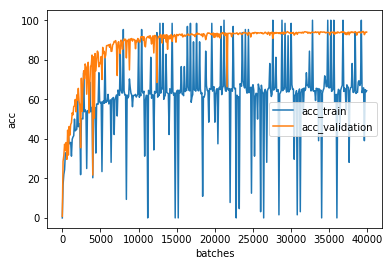

In [26]:
record_acc_train = [xx[1] for xx in records]
record_acc_val = [xx[2] for xx in records]

plt.plot(np.arange(len(records))*100, record_acc_train, label='acc_train')
plt.plot(np.arange(len(records))*100, record_acc_val, label='acc_validation')
plt.xlabel('batches')
plt.ylabel('acc')
plt.legend()
plt.show()

In [27]:
net.eval()

test_rights = []

for idx, data_test in enumerate(zip(test_loader1, test_loader2)):
    ((xt1, yt1), (xt2, yt2)) = data_test
    xt1, xt2 = Variable(xt1).cuda(), Variable(xt2).cuda()
    label = yt1+yt2
    outputs = net(xt1, xt2)
    right = rightness(outputs.data, label)
    test_rights.append(right)

    
print(np.mean(test_rights))

62.5316455696
